### Process geopandas .parquet. cell segmentation for ELLA

If you have segmented cells as shapely formats in a geopandas .parquet., it can be easly converted to the format that ELLA takes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

In [2]:
# let's use 10x cell segmentation as a demo
# you can get this from 10x website or switch this to your own .parquet
path = 'your_own_dir/10x_raw/breast_cancer_sample1_rep1/outs/cell_boundaries.parquet'

In [3]:
# --- This BLOCK is not in use ---
# read the cell_boundaries.parquet file
# import geopandas as gpd
# cell_bound = gpd.read_parquet(path)

# got an error: Missing geo metadata in Parquet/Feather file.
# so I switch to using pandas

In [4]:
# use pandas to read the .parquet file
cell_bound_df = pd.read_parquet(path)
print(cell_bound_df.head())

# this is the format that ELLA takes (shown here: https://jadexq.github.io/ELLA/inputs.html) 
# one column for cell id, the other two columns for the x and y coordinates cell segmentation polygon points
# BUT, if we look into it, there are too few points that defines a cell segmentation polygon
cid = 1
cbound = cell_bound_df[cell_bound_df.cell_id==1]
print(f'number of cell segmentation polygon points for cell {cid} is only {len(cbound)}')

# ELLA needs MORE POINTS (e.g. 100, depending on the resolution of the expression data) to calculate the "relative positions" 
# So we may do some interpolation

   cell_id    vertex_x    vertex_y
0        1  849.787476  322.362488
1        1  844.262512  323.212494
2        1  841.500000  324.487488
3        1  843.200012  327.250000
4        1  844.900024  328.737488
number of cell segmentation polygon points for cell 1 is only 13


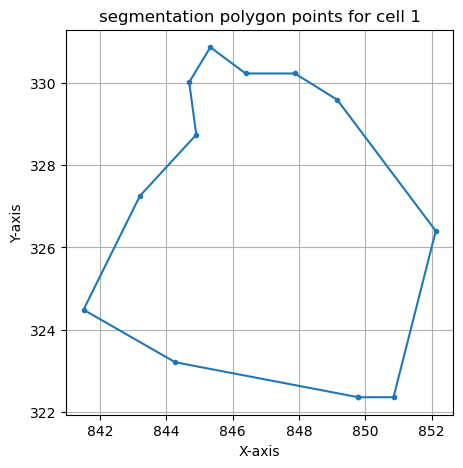

In [5]:
# visulize the original segmentation polygon points
plt.figure(figsize=(5, 5))
plt.plot(cbound.vertex_x, cbound.vertex_y, marker='.')
plt.title(f'segmentation polygon points for cell {cid}')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)

In [6]:
# the interpolated cell segmentation polygon points and the input for ELLA

# conver to shapely polygon
cbound_shape = Polygon(list(zip(cbound.vertex_x.values, cbound.vertex_y.values)))
# get more points from the shapely polygon
num_points = 100 # <<< input
print(f'increase the number of points to {num_points}')
more_points = [cbound_shape.boundary.interpolate(distance, normalized=True) for distance in np.linspace(0, 1, num_points)]

# create a df for ELLA 
coords = [(point.x, point.y) for point in more_points]
cell_bound_more_points = pd.DataFrame(coords, columns=['x', 'y'])
cell_bound_more_points['cell'] = cid
print(f'the input for ELLA:\n{cell_bound_more_points.head()}')

increase the number of points to 100
the input for ELLA:
            x           y  cell
0  849.787476  322.362488     1
1  849.484985  322.409026     1
2  849.182493  322.455563     1
3  848.880002  322.502101     1
4  848.577511  322.548639     1


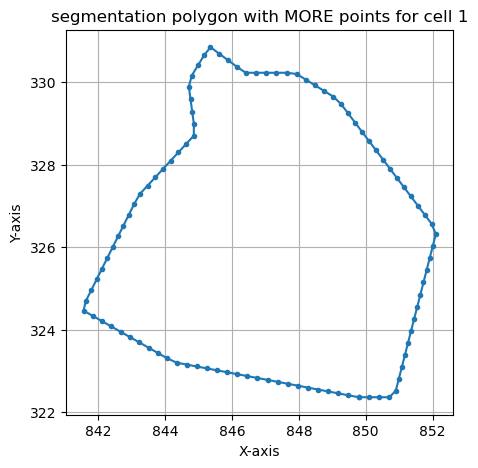

In [7]:
# visulize the inputed segmentation polygon points
plt.figure(figsize=(5, 5))
plt.plot(cell_bound_more_points.x, cell_bound_more_points.y, marker='.')
plt.title(f'segmentation polygon with MORE points for cell {cid}')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)